In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [3]:
model_path = '/home/horyctom/bias-detection-thesis/src/models/trained/subj_balanced.pth'

## Data

In [4]:
mpqa = load_dataset('csv',data_files = CS_DATA_PATH + 'MPQA/mpqa.csv')['train']
subj = load_dataset('csv',data_files = CS_DATA_PATH + 'SUBJ/subj.csv')['train']

subj = concatenate_datasets([subj,resample(mpqa)])
subj = subj.shuffle(seed=42)

In [5]:
tokenized = preprocess_data(subj,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

## Training

In [8]:
pretraining_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=100,
    logging_steps=100,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
100,0.420000,0.301764,0.875721
200,0.335700,0.293152,0.881113
300,0.299600,0.286024,0.883460
400,0.290600,0.299814,0.881706
500,0.282100,0.253121,0.891071
600,0.219600,0.271460,0.894761
700,0.180100,0.282807,0.896200
800,0.178900,0.274179,0.894074
900,0.181500,0.278717,0.893508
1000,0.177600,0.267468,0.899720


TrainOutput(global_step=2680, training_loss=0.1344313650433697, metrics={'train_runtime': 680.9784, 'train_samples_per_second': 125.738, 'train_steps_per_second': 3.936, 'total_flos': 3063258128698080.0, 'train_loss': 0.1344313650433697, 'epoch': 5.0})

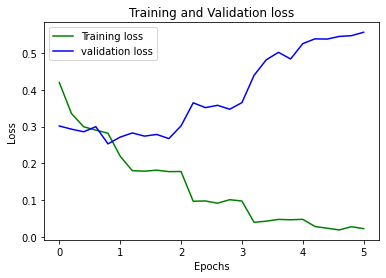

In [10]:
plot_losses(pd.read_csv('subj.loss',sep='\t'))

In [12]:
pretraining_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=32,  
    logging_steps=20,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [13]:
tokenized = preprocess_data(subj,tokenizer,'sentence')

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized,compute_metrics=compute_metrics_eval)
trainer.train()

torch.save(model.state_dict(),balanced_path)

Step,Training Loss
20,0.580300
40,0.474500
60,0.378100
80,0.419600
100,0.408200
120,0.360100
140,0.356500
160,0.334600
180,0.314900
200,0.292000
